In [1]:
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

import os
import natsort
from PIL import Image
from torchvision.transforms import ToPILImage
import copy
from matplotlib.ticker import MultipleLocator

In [2]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:5000px;
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

In [3]:
class PhotosDataset(Dataset):
    def __init__(self, images_dir):
        self.images_dir = images_dir
        self.image_names = natsort.natsorted(os.listdir(images_dir))     
        
    def __len__(self):
        return len(self.image_names)
                   
    def __getitem__(self, idx):
        image_loc = os.path.join(self.images_dir, self.image_names[idx])
        image = Image.open(image_loc).convert("RGB")
        return image
    
def tonp(image): # (100, 100, 3)
    return np.array(image)

def topil(array):
    return ToPILImage()(array)

def tonp2(image): # (3, 100, 100)
    return np.array(image).transpose(2, 0, 1)

def topil2(array):
    return ToPILImage()((array).transpose(1, 2, 0))

def tobw(image, threshold):
    arr = tonp2(image)
    new_arr = np.zeros_like(arr)
    new_arr[:, arr[0] + arr[1] + arr[2] <= threshold] = 255
    return topil2(new_arr)

def getpix(image, i, j):
    arr = tonp(image)
    return arr[i, j]

def putpix(image, i, j, color):
    arr = tonp(image)
    arr[i, j] = np.array(color)
    return topil(arr)

In [4]:
def show(image, figsize=(7, 7)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(image)
    plt.axis('off')
    print("Image shape: ", tonp(image).shape)
    plt.show()

In [5]:
data_path = "./training"
PD = PhotosDataset(data_path)

In [6]:
def tobin3(image, threshold=120):
    arr = tonp2(image).astype(int)
    return np.sum(arr, axis=0) > threshold

def bin_to_image(array):
    arr = np.zeros((3, array.shape[0], array.shape[1]))
    for i in range(3):
        arr[i, :, :] = array * 255
    return topil2(arr.astype(np.uint8))


def conv(image, n):
    if n <= 1:
        return image
    arr = tonp2(image)
    new_arr = copy.copy(arr)
    for i in range(new_arr.shape[1] // n):
        for j in range(new_arr.shape[2] // n):
            for k in range(3):
                new_arr[k, i*n:i*n + n, j*n:j*n + n] = np.mean(arr[k, i*n:i*n + n, j*n:j*n + n])
    return topil2(new_arr)

def conv2(image, n):
    if n <= 1:
        return image
    arr = tonp2(image)
    new_arr = np.zeros((3, arr.shape[1]//n, arr.shape[2]//n), dtype=np.uint8)
    for i in range(new_arr.shape[1]):
        for j in range(new_arr.shape[2]):
            for k in range(3):
                new_arr[k, i, j] = arr[k, i*n, j*n]
    return topil2(new_arr)

In [7]:
class Marcher:
    def __init__(self):
        pass

    def find_bin_center(self):
        dist_matr = np.fromfunction(lambda i, j: (self.array.shape[0] // 2 - i) ** 2 + (self.array.shape[1] // 2 - j) ** 2,
                                    shape=self.array.shape)
        dist_matr[(1 - self.array).astype(bool)] = 1e6
        best_ind = np.argmin(dist_matr)
        self.ind = (best_ind // self.array.shape[1], best_ind % self.array.shape[1])
    
    def go_left(self):
        self.ind = list(self.ind)
        while self.array[self.ind[0], self.ind[1] - 1] != 0:
            self.ind[1] -= 1
        self.ind = tuple(self.ind)
    
    def step(self, first_step=False):
        if not first_step:
            self.path[self.ind] = 0
        else:
            self.path[self.ind] = 1
        next_ind_flat = np.argmax(self.path[max(self.ind[0] - 1, 0):min(self.ind[0] + 2, self.path.shape[0]), max(self.ind[1] - 1, 0):min(self.ind[1] + 2, self.path.shape[1])])
        next_ind = (next_ind_flat // 3, next_ind_flat % 3)        
        hor_bias = next_ind[1] - 1
        ver_bias = next_ind[0] - 1
        next_ind = (self.ind[0] + next_ind[0] - 1, self.ind[1] + next_ind[1] - 1)
        if not self.accum:
            direction = np.arctan2(-ver_bias, hor_bias) * 4 / np.pi
        else:
            direction = self.dirs[-1] + np.arctan2(-ver_bias, hor_bias) * 4 / np.pi
        self.ind = next_ind
        
        if not first_step and abs(direction - self.dirs[-1]) > 4:
            direction += 7*(2*(float(direction<self.dirs[-1]) - 0.5))
        return direction
    
    def perimeter_march(self):
        self.path = np.zeros_like(self.array).astype(int)
        for i, j in opt_perimeter(self.array):
            self.path[i, j] = 2
        inds = [self.ind]
        start_pos = self.ind
        if not self.accum:
            self.dirs = []
        else:
            self.dirs = [0]
        self.dirs += [self.step(first_step=True)]
        inds += [self.ind]
        while self.ind != start_pos:
            self.dirs += [self.step()]
            inds += [self.ind]
        if not self.accum:
            return self.dirs, inds[:-1]
        else:
            return self.dirs[1:], inds[:-1]
    
    def make(self, array, accum=False):
        self.array = array.astype(int)
        self.accum = accum
        self.find_bin_center()
        self.go_left()
        pm = self.perimeter_march()
        return np.array(pm[0]), np.array(pm[1])

In [8]:
def perimeter(array):
    res = []
    plus_ind = np.where(array != 0)
    for i, j in zip(plus_ind[0], plus_ind[1]):
        loc_array = [array[max(i - 1, 0), j], array[min(i + 1, array.shape[0] - 1), j], array[i, max(j - 1, 0)], array[i, min(j + 1, array.shape[1] - 1)]]
        if np.sum(loc_array) < 4:
            res += [(i, j)]
    return res
            

def opt_perimeter(array):
    res = []
    ch_array = copy.copy(array).astype(int)
    for i, j in perimeter(array):
        ch_array[i, j] = -1
    for i, j in perimeter(array):
        loc_array = [ch_array[max(i - 1, 0), j], ch_array[min(i + 1, ch_array.shape[0] - 1), j], ch_array[i, max(j - 1, 0)], ch_array[i, min(j + 1, ch_array.shape[1] - 1)]]
        if np.max(loc_array) == 1:
            res += [(i, j)]
    return res

In [9]:
def equanize(array):
    k = 3
    buf_array = np.zeros(array.shape[0] // k)
    for i in range(array.shape[0] // k):
        buf_array[i] = array[k*i + np.argmax(np.abs(array[k*i:k*(i+1)]))]
    return buf_array

def equanize2(array):
    k = 2
    buf_array = np.zeros(array.shape[0] // k)
    for i in range(array.shape[0] // k):
        loc_arr = np.unique(array[k*i:k*(i+1)], return_counts=True)
        buf_array[i] = loc_arr[0][np.argmax(loc_arr[1])]
    return buf_array

In [10]:
class Fracter:
    def __init__(self):
        pass
    
    def flat(self, x):
        res = np.zeros_like(x)
        stable = x[0]
        alpha = 0.5
        for i in range(len(x) - 3):
            res[i] = stable = alpha * stable + (1 - alpha) * (x[i+2]+x[i+1]+x[i])/3
            for i in range(3):
                res[i - 3] = x[-1] * (i+1) / 3 + res[-4] * (2 - i) / 3
        return res
    
    def fract(self, x, threshold=0.3):
        res1 = []
        res2 = [0]
        for i in range(1, len(x)):
            if abs(x[i - 1] - x[i]) > threshold:
                res1 += [i]
            else:
                res2 += [i]
        return res1, res2

In [11]:
def bin_and_depend(bimg):
    buf = bin_to_image(bimg)
    
    F = Fracter()
    M = Marcher()
    directions, path = M.make(bimg)
    if len(directions) < 25:
        raise ValueError
    flatdirs = F.flat(directions)
    
    
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(directions)
    ax.scatter(np.arange(len(directions)), directions)
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.grid()
    plt.show()
    
    
    for i in range(3):
        flatdirs = F.flat(flatdirs)
    fracts, stables = F.fract(flatdirs, 0.1)
    
    
    fig, ax = plt.subplots(figsize=(15, 5))

    ax.plot(flatdirs)
    ax.scatter(stables, flatdirs[stables])
    
    ax.scatter(stables, flatdirs[stables], linewidth=10)
    ax.scatter(fracts, flatdirs[fracts])
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.grid()
    
    
    for s in stables:
        buf = putpix(buf, path[s][0], path[s][1], np.array([255, 155, 0]))
    for s in fracts:
        buf = putpix(buf, path[s][0], path[s][1], np.array([0, 55, 255]))
    
    buf = putpix(buf, path[0][0], path[0][1], np.array([200, 55, 55]))
    buf = putpix(buf, path[1][0], path[1][1], np.array([60, 105, 5]))
    
    st = 0
    end = 0
    
    pretenders = []
    pretenders_values = []
    
    mean_fracts = []
    
    while st < len(fracts) and end < len(fracts):
        while end < len(fracts) and fracts[end] - 1 == fracts[end - 1]:
            end += 1
        end -= 1
        if end - st > 1:
            sind = (fracts[st] + fracts[end]) // 2
            pretenders += [sind]
            pretenders_values += [abs(flatdirs[fracts[st]] - flatdirs[fracts[end]])]
            ax.scatter(sind, flatdirs[sind], color='red')
            
            mean_fracts += [flatdirs[sind]]
        st = end + 1
        end = st + 1
    
    pretenders = np.array(pretenders)
    pretenders_values = np.array(pretenders_values)
    sorted_pretenders_inds = np.argpartition(-pretenders_values, kth=min(len(pretenders) - 1, 10))[:10]
    sorted_pretenders = pretenders[sorted_pretenders_inds]
    sorted_pretenders = sorted_pretenders[:9]
        
    for sp in sorted_pretenders:
        buf = putpix(buf, path[sp][0], path[sp][1], np.array([255, 0, 0]))
    
    new_pretenders = []
    if abs(mean_fracts[1] - mean_fracts[0]) < 1.5 and pretenders_values[0] + pretenders_values[1] > 1.5*1.5: ### !!!
        new_pretenders += [pretenders[0]]
    for i in range(1, len(pretenders) - 1):
        if (abs(mean_fracts[i + 1] - mean_fracts[i]) < 1.5 and pretenders_values[i] > 1.5 and pretenders_values[i + 1] > 1.5 or 
            abs(mean_fracts[i - 1] - mean_fracts[i]) < 1.5 and pretenders_values[i] > 1.5 and pretenders_values[i - 1] > 1.5):
            new_pretenders += [pretenders[i]]
    if abs(mean_fracts[-1] - mean_fracts[-2]) < 1.5 and pretenders_values[-1] > 1.5:
        new_pretenders += [pretenders[-1]]
    
    if len(new_pretenders) == 9:
        fig, ax = plt.subplots(figsize=(7, 7))
        ax.imshow(buf)
        plt.axis('off')
        for npr, i in zip(new_pretenders, range(len(new_pretenders))):
            buf = putpix(buf, path[npr][0], path[npr][1], np.array([255, 0, 255]))
            ax.plot([path[new_pretenders[i - 1]][1], path[new_pretenders[i]][1]], [path[new_pretenders[i - 1]][0], path[new_pretenders[i]][0]])
        plt.show()
        show(buf)
        return path, new_pretenders
    
    if len(new_pretenders) < 9:
        while len(new_pretenders) < 9:
            sortset = np.array(list(set(sorted_pretenders) - set(new_pretenders)))
            mean = np.mean(new_pretenders)
            sortset2 = np.abs(sortset - mean)
            new_pretenders = sorted(new_pretenders + [sortset[np.argmax(sortset2)]])
        
        fig, ax = plt.subplots(figsize=(7, 7))
        ax.imshow(buf)
        plt.axis('off')
        for npr, i in zip(new_pretenders, range(len(new_pretenders))):
            buf = putpix(buf, path[npr][0], path[npr][1], np.array([255, 0, 255]))
            ax.plot([path[new_pretenders[i - 1]][1], path[new_pretenders[i]][1]], [path[new_pretenders[i - 1]][0], path[new_pretenders[i]][0]])
        plt.show()
        show(buf)
        return path, new_pretenders
    
    new_pretenders = []
    for i in range(9):
        if pretenders_values[i] >= 2.5 or (pretenders_values[i] >= 1.5 and pretenders_values[i + 1] >= 2.5):
            new_pretenders += [pretenders[i]]
        else:
            break
    for i in range(len(pretenders) - 1, len(pretenders) + len(new_pretenders) - 9 - 1, -1):
        if pretenders_values[i] > 1.5:
            new_pretenders = [pretenders[i]] + new_pretenders
        else:
            break
    
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(buf)
    plt.axis('off')
    for npr, i in zip(new_pretenders, range(len(new_pretenders))):
        buf = putpix(buf, path[npr][0], path[npr][1], np.array([255, 0, 255]))
        ax.plot([path[new_pretenders[i - 1]][1], path[new_pretenders[i]][1]], [path[new_pretenders[i - 1]][0], path[new_pretenders[i]][0]])
    plt.show()
    show(buf)
    return path, new_pretenders

In [18]:
class Fingers_Searcher:
    def __init__(self):
        self.F = Fracter()
        self.M = Marcher()
    
    def image_to_dir(self, binarized):
        self.buf = bin_to_image(binarized)
        self.directions, self.path = self.M.make(binarized)
        if len(self.directions) < 25:
            raise ValueError
        self.flatdirs = self.F.flat(self.directions)
        
        for i in range(3):
            self.flatdirs = self.F.flat(self.flatdirs)
        self.fracts, self.stables = self.F.fract(self.flatdirs, 0.1)
        
    def first_pretenders(self):
        st = 0
        end = 0
        self.pretenders = []
        self.pretenders_values = []
        self.mean_fracts = []
        while st < len(self.fracts) and end < len(self.fracts):
            while end < len(self.fracts) and self.fracts[end] - 1 == self.fracts[end - 1]:
                end += 1
            end -= 1
            if end - st > 1:
                sind = (self.fracts[st] + self.fracts[end]) // 2
                self.pretenders += [sind]
                self.pretenders_values += [abs(self.flatdirs[self.fracts[st]] - self.flatdirs[self.fracts[end]])]
                #ax.scatter(sind, self.flatdirs[sind], color='red')
                self.mean_fracts += [self.flatdirs[sind]]
            st = end + 1
            end = st + 1
        self.pretenders = np.array(self.pretenders)
        self.pretenders_values = np.array(self.pretenders_values)
        sorted_pretenders_inds = np.argpartition(-self.pretenders_values, kth=min(len(self.pretenders) - 1, 10))[:10]
        self.sorted_pretenders = self.pretenders[sorted_pretenders_inds]
        self.sorted_pretenders = self.sorted_pretenders[:9]
        
    def second_pretenders(self):
        self.new_pretenders = []
        if abs(self.mean_fracts[1] - self.mean_fracts[0]) < 1.5 and self.pretenders_values[0] + self.pretenders_values[1] > 1.5*1.5: ### !!!
            self.new_pretenders += [self.pretenders[0]]
        for i in range(1, len(self.pretenders) - 1):
            if (abs(self.mean_fracts[i + 1] - self.mean_fracts[i]) < 1.5 and self.pretenders_values[i] > 1.5 and self.pretenders_values[i + 1] > 1.5 or 
                abs(self.mean_fracts[i - 1] - self.mean_fracts[i]) < 1.5 and self.pretenders_values[i] > 1.5 and self.pretenders_values[i - 1] > 1.5):
                self.new_pretenders += [self.pretenders[i]]
        if abs(self.mean_fracts[-1] - self.mean_fracts[-2]) < 1.5 and self.pretenders_values[-1] > 1.5:
            self.new_pretenders += [self.pretenders[-1]]
    
    def sort_fingers(self):
        coord1 = np.array(self.path[self.new_pretenders]).T
        coord2 = np.zeros_like(coord1)
        coord2[:, :-1] = coord1[:, 1:]
        coord2[:, -1] = coord1[:, 0]
        dists = (coord1[0] - coord2[0]) ** 2 + (coord1[1] - coord2[1]) ** 2
        max_dist = np.argmax(dists)
        
        #fig, ax = plt.subplots(figsize=(7, 7))
        #ax.imshow(self.buf)
        #plt.axis('off')
        if max_dist + 1 < len(self.new_pretenders):
            maxi = max_dist + 1
        else:
            maxi = 0
        #ax.plot([self.path[self.new_pretenders[max_dist]][1], self.path[self.new_pretenders[maxi]][1]], 
        #        [self.path[self.new_pretenders[max_dist]][0], self.path[self.new_pretenders[maxi]][0]], 
        #        linewidth=5)
        #plt.show()
        
        if maxi != 0:
            self.new_pretenders = np.array(list(self.new_pretenders[maxi:]) + list(self.new_pretenders[:maxi]))
            
    
    def ret(self):
        fig, ax = plt.subplots(figsize=(7, 7))
        ax.imshow(self.buf)
        plt.axis('off')
        ax.plot(self.path[self.new_pretenders][:, 1], self.path[self.new_pretenders][:, 0], color='red', linewidth=3)
        ax.scatter(self.path[self.new_pretenders][:, 1], self.path[self.new_pretenders][:, 0], color='orange', linewidth=3)
        plt.show()
    
    def finale(self):
        if len(self.new_pretenders) == 9:
            return

        if len(self.new_pretenders) < 9:
            while len(self.new_pretenders) < 9:
                sortset = np.array(list(set(self.sorted_pretenders) - set(self.new_pretenders)))
                mean = np.mean(self.new_pretenders)
                sortset2 = np.abs(sortset - mean)
                self.new_pretenders = sorted(self.new_pretenders + [sortset[np.argmax(sortset2)]])
            return
        
        self.new_pretenders = []
        for i in range(9):
            if self.pretenders_values[i] >= 2.5 or (self.pretenders_values[i] >= 1.5 and self.pretenders_values[i + 1] >= 2.5):
                self.new_pretenders += [self.pretenders[i]]
            else:
                break
        for i in range(len(self.pretenders) - 1, len(self.pretenders) + len(self.new_pretenders) - 9 - 1, -1):
            if self.pretenders_values[i] > 1.5:
                self.new_pretenders = [self.pretenders[i]] + self.new_pretenders
            else:
                break
        return
    
    
    def make_FS(self, binarized):
        self.image_to_dir(binarized)
        self.first_pretenders()
        self.second_pretenders()
        self.finale()

In [16]:
class Raiden:
    def __init__(self):
        self.FS = Fingers_Searcher()
    
    def by_the_elder_gods(self, img):
        success = False
        k = 7
        while not success:
            try:
                b = tobin3(conv2(conv(img, k), k), 150)
                b[0, :] = 0
                b[-1, :] = 0
                b[:, 0] = 0
                b[:, -1] = 0
                self.FS.make_FS(b)
                success = True
            except ValueError:
                k -= 1
        self.FS.sort_fingers()
        #self.FS.ret()
        
        self.FS.buf = img
        self.FS.path *= k
        self.FS.path += 5
        self.FS.ret()

### Запустите ячейку ниже, чтобы программа начала работать над всеми 99 изображениями (конечный результат работы алгоритма).

0


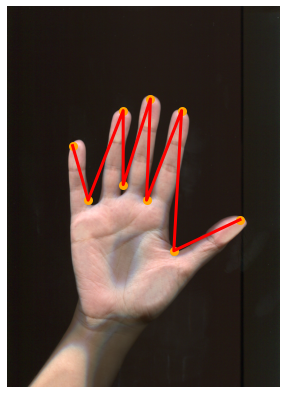

In [23]:
R = Raiden()
for i in range(99):
    print(i)
    image_names = natsort.natsorted(os.listdir(data_path))    
    image_loc = os.path.join(data_path, image_names[1])
    R.by_the_elder_gods(PD[i])

### Запустите ячейку ниже, чтобы программа начала работать над всеми 99 изображениями (промежуточные этапы алгоритма). Осторожно: на изображения будет много расходоваться ресурсов ноутбука.

0
Image shape:  (684, 489, 3)


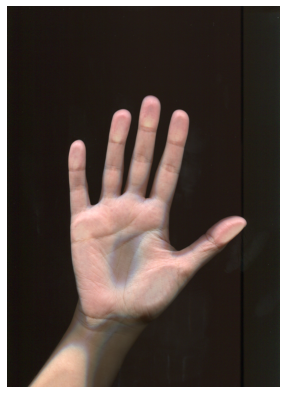

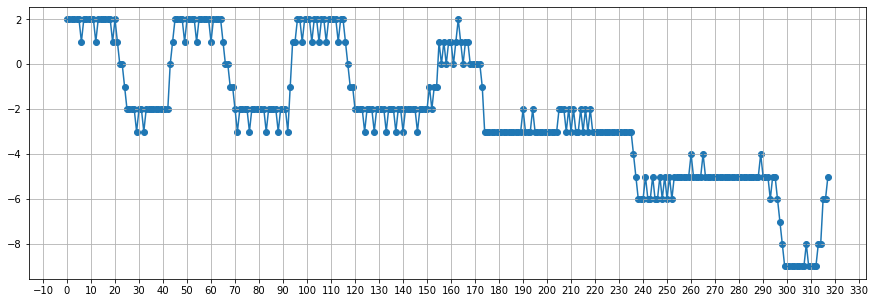

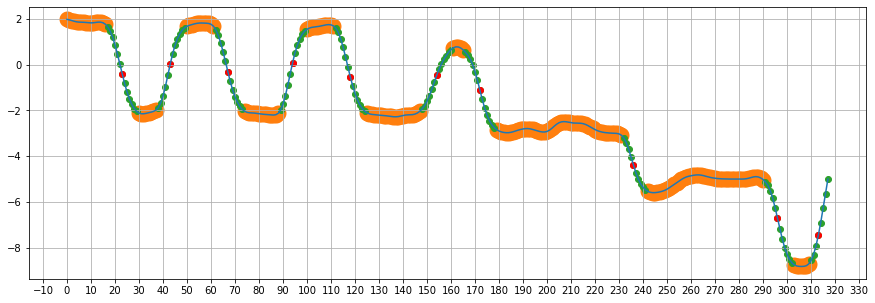

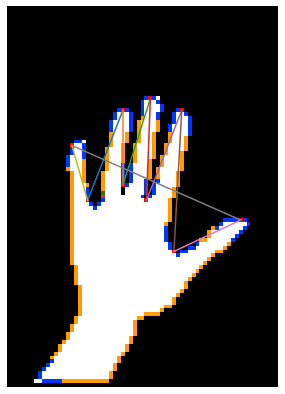

Image shape:  (97, 69, 3)


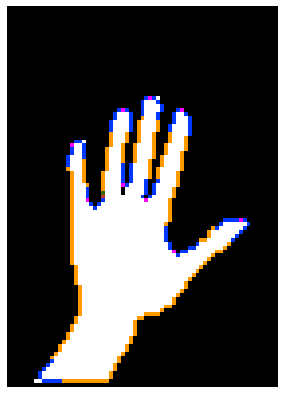

In [21]:
for i in range(99):
    print(i)
    success = False
    k = 7
    while not success:
        try:
            show(PD[i])
            b = tobin3(conv2(conv(PD[i], k), k), 150)
            b[0, :] = 0
            b[-1, :] = 0
            b[:, 0] = 0
            b[:, -1] = 0
            bin_and_depend(b)
            success = True
        except ValueError:
            k -= 1